# HW4P2: Attention-based Speech Recognition


HW Writeup: https://piazza.com/class_profile/get_resource/l37uyxe87cq5xn/lam1lcjjj0314e <br>
Kaggle competition link: https://www.kaggle.com/competitions/11-785-f22-hw4p2/ <br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# Initial Set-up

In [ ]:
!nvidia-smi

Tue Dec 13 08:04:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    54W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb

     |████████████████████████████████| 1.9 MB 40.1 MB/s 
     |████████████████████████████████| 174 kB 86.8 MB/s 
     |████████████████████████████████| 2.2 MB 70.2 MB/s 
     |████████████████████████████████| 182 kB 100.5 MB/s 
     |████████████████████████████████| 168 kB 97.3 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 168 kB 92.3 MB/s 
     |████████████████████████████████| 166 kB 107.1 MB/s 
     |████████████████████████████████| 166 kB 100.6 MB/s 
     |████████████████████████████████| 162 kB 99.0 MB/s 
     |████████████████████████████████| 162 kB 103.1 MB/s 
     |████████████████████████████████| 158 kB 84.7 MB/s 
     |████████████████████████████████| 157 kB 105.7 MB/s 
     |████████████████████████████████| 157 kB 105.2 MB/s 
     |████████████████████████████████| 157 kB 105.8 MB/s 
     |████████████████████████████████| 157 kB 106.1 MB/s 
     |████████████████████████████████| 157 kB 106.4 MB/s 
     |█

# Import

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import Levenshtein

import torch
import torchaudio
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import gc
from torchsummaryX import summary
import wandb
from glob import glob
from torch import nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive')

Mounted at /content/drive


# Config

In [ ]:
# Global config dict. Feel free to add or change if you want.
config = {
    'batch_size': 96,
    'epochs': 70,
    'lr': 1e-3
}

# Toy Data Setup

The toy dataset is very essential for you in this HW. The model which you will be building is complicated and you first need to make sure that it runs on the toy dataset. <br>
In other words, you need convergence - the attention diagonal. Take a look at the write-up for this. <br>
We have given you the following code to download the toy data and load it. You can use it the way it is. But be careful, the transcripts are different from the original data from kaggle. The toy dataset has phonemes but the actual data has characters.

In [ ]:
!wget -q https://cmu.box.com/shared/static/wok08c2z2dp4clufhy79c5ee6jx3pyj9 --content-disposition --show-progress
!wget -q https://cmu.box.com/shared/static/zctr6mvh7npfn01forli8n45duhp2g85 --content-disposition --show-progress
!wget -q https://cmu.box.com/shared/static/m2oaek69145ljeu6srtbbb7k0ip6yfup --content-disposition --show-progress
!wget -q https://cmu.box.com/shared/static/owrjy0tqra3v7zq2ru7mocy2djskydy9 --content-disposition --show-progress

f0176_mfccs_train.n 100%[===================>] 279.30M  14.4MB/s    in 20s     
f0176_mfccs_dev.npy 100%[===================>]  27.93M  13.8MB/s    in 2.0s    
f0176_hw3p2_train.n 100%[===================>]   7.02M  5.54MB/s    in 1.3s    
f0176_hw3p2_dev.npy 100%[===================>] 718.88K   959KB/s    in 0.7s    


In [ ]:
# Load the toy dataset
X_train = np.load("f0176_mfccs_train.npy")
X_valid = np.load("f0176_mfccs_dev.npy")
Y_train = np.load("f0176_hw3p2_train.npy")
Y_valid = np.load("f0176_hw3p2_dev.npy")

# This is how you actually need to find out the different trancripts in a dataset. 
# Can you think whats going on here? Why are we using a np.unique?
VOCAB_MAP           = dict(zip(np.unique(Y_valid), range(len(np.unique(Y_valid))))) 
VOCAB_MAP["[PAD]"]  = len(VOCAB_MAP)
VOCAB               = list(VOCAB_MAP.keys())

SOS_TOKEN = VOCAB_MAP["[SOS]"]
EOS_TOKEN = VOCAB_MAP["[EOS]"]

PAD_TOKEN = VOCAB_MAP["[PAD]"]

Y_train = [np.array([VOCAB_MAP[p] for p in seq]) for seq in Y_train]
Y_valid = [np.array([VOCAB_MAP[p] for p in seq]) for seq in Y_valid]

In [ ]:
# Dataset class for the Toy dataset
class ToyDataset(torch.utils.data.Dataset):

    def __init__(self, partition):

        if partition == "train":
            self.mfccs = X_train[:, :, :15]
            self.transcripts = Y_train

        elif partition == "valid":
            self.mfccs = X_valid[:, :, :15]
            self.transcripts = Y_valid

        assert len(self.mfccs) == len(self.transcripts)

        self.length = len(self.mfccs)

    def __len__(self):

        return self.length

    def __getitem__(self, i):

        x = torch.tensor(self.mfccs[i])
        y = torch.tensor(self.transcripts[i])

        return x, y

    def collate_fn(self, batch):

        x_batch, y_batch = list(zip(*batch))

        x_lens      = [x.shape[0] for x in x_batch] 
        y_lens      = [y.shape[0] for y in y_batch] 

        x_batch_pad = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value= EOS_TOKEN)
        y_batch_pad = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value= EOS_TOKEN) 
        
        return x_batch_pad, y_batch_pad, torch.tensor(x_lens), torch.tensor(y_lens)

In [ ]:
train_data=ToyDataset("train")
valid_data=ToyDataset("valid")
train_loader = torch.utils.data.DataLoader(train_data, num_workers= 2,
                                           batch_size=config['batch_size'], pin_memory= True,
                                           shuffle= True,collate_fn=train_data.collate_fn)
val_loader = torch.utils.data.DataLoader(valid_data, num_workers= 2,
                                           batch_size=config['batch_size'], pin_memory= True,
                                           shuffle= True,collate_fn=train_data.collate_fn)
for data in train_loader:
    
    example_batch=data
    break 


In [ ]:
# TODO: Use the same Kaggle code from HW1P2, HW2P2, HW3P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle/

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"shenyix","key":"c6455229fb59a0255b82591d44d4a323"}')

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 7.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73274 sha256=115ff0b336d18688239150f8440fce0f4dcc0aaf9b330c8f8b9f7dc6e5d94505
  Stored in directory: /root/.cache/pip/wheels/f3/67/7b/a6d668747974998471d29b230e7221dd01330ac34faebe4af4
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
# Download the data
!kaggle competitions download -c 11-785-f22-hw4p2
!mkdir '/content/data'

!unzip -qo '11-785-f22-hw4p2.zip' -d '/content/data'

100% 2.08G/2.09G [01:47<00:00, 21.4MB/s]
100% 2.09G/2.09G [01:47<00:00, 20.9MB/s]


# Dataset Class

In [ ]:
# These are the various characters in the transcripts of the datasetW
VOCAB = ['<sos>',   
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         '<eos>']

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

In [ ]:
class AudioDataset(torch.utils.data.Dataset):

    #TODO
    def __init__(self, partition= "train",transformer=None): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''
        self.partition=partition
        self.transform=transformer

        if partition=="train":
          data_path='/content/data/hw4p2/train-clean-100'
        else:
          data_path='/content/data/hw4p2/dev-clean'
        self.mfcc_dir = data_path+'/mfcc'
        self.transcript_dir = data_path+'/transcript/raw'


        mfcc_names = (os.listdir(self.mfcc_dir))
        transcript_names =(os.listdir(self.transcript_dir))
        mfcc_names.sort()
        transcript_names.sort()


        # Creating Array

        self.mfccs, self.transcripts = [], []
        self.VOCAB = VOCAB
        def helper(x):
          return self.VOCAB.index(x)

       
        # Iterate through mfccs and transcripts
        for i in range(0, len(mfcc_names)):
       
            mfcc =np.load(self.mfcc_dir+"/"+mfcc_names[i],allow_pickle=True)
            #normalize
            mfcc=(mfcc-mfcc.mean(axis=0))/mfcc.std(axis=0)
            transcript = np.load(self.transcript_dir+"/"+transcript_names[i],allow_pickle=True)
            transcript.reshape(1,transcript.shape[0])
            transcript=np.vectorize(helper)(transcript)
            
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)


        self.length = len(mfcc_names)

    def __len__(self):
        
        return self.length
       

    def __getitem__(self, ind):
      
        mfcc =  self.mfccs[ind]
        transcript =self.transcripts[ind]
        return mfcc, transcript


    def collate_fn(self,batch):
        batch_mfcc =[torch.from_numpy(x[0]) for x in batch]
        batch_transcript = [torch.from_numpy(x[1]) for x in batch]
        batch_mfcc_pad = pad_sequence(batch_mfcc,batch_first=True,padding_value=EOS_TOKEN)
        batch_transcript_pad = pad_sequence(batch_transcript,batch_first=True,padding_value=EOS_TOKEN)
        lengths_mfcc =[ len(x) for x in batch_mfcc]
        lengths_transcript =[len(x) for x in batch_transcript]
        if self.partition=="train":
          batch_mfcc_pad=self.transform(batch_mfcc_pad)
         
       

        
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

       

In [ ]:
class AudioTestDataset(torch.utils.data.Dataset):
    def __init__(self,data_path): 
        self.data_path =data_path
        mfcc_names = (os.listdir(self.data_path))
        mfcc_names.sort() 
        self.mfccs=[]


        for i in range(0, len(mfcc_names)):
            mfcc =np.load(self.data_path+"/"+mfcc_names[i],allow_pickle=True)
            mfcc=(mfcc-mfcc.mean(axis=0))/mfcc.std(axis=0)

            self.mfccs.append(mfcc)

        self.length = len(self.mfccs)
    def __len__(self):
      return self.length

    def __getitem__(self, ind):
      return self.mfccs[ind]


    def collate_fn(self,batch):
        batch_mfcc =[torch.from_numpy(x) for x in batch]
        batch_mfcc_pad = pad_sequence(batch_mfcc,batch_first=True,padding_value=EOS_TOKEN)
      
        lengths_mfcc =[len(x) for x in batch_mfcc]
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)


In [ ]:
print(len(VOCAB))

30


# Dataset and Dataloaders

In [ ]:
import gc 
gc.collect()

16

### Transform/Augmentation

In [ ]:
class Transform(torch.nn.Module):
    def __init__(self,time_mask_param=120,freq_mask_param=6):
        super().__init__()
        

        self.spec_aug = torch.nn.Sequential(
            torchaudio.transforms.FrequencyMasking(freq_mask_param),
            torchaudio.transforms.TimeMasking(time_mask_param)
        )


    def forward(self, waveform):
        # Resample the input
        
        # Apply SpecAugment
        waveform=waveform.permute(0,2,1)
        waveform =self.spec_aug(waveform)
        waveform=waveform.permute(0,2,1)

       

        return waveform


In [ ]:
transformer=Transform(60,4)
train_data = AudioDataset("train",transformer) 
val_data =  AudioDataset("valid")
test_data = AudioTestDataset("/content/data/hw4p2/test-clean/mfcc")

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, num_workers= 2, 
                                          batch_size=config['batch_size'], pin_memory= True, 
                                          shuffle= False,collate_fn=test_data.collate_fn)


train_loader = torch.utils.data.DataLoader(train_data, num_workers= 2,
                                           batch_size=config['batch_size'], pin_memory= True,
                                           shuffle= True,collate_fn=train_data.collate_fn)

val_loader = torch.utils.data.DataLoader(val_data, num_workers= 2,
                                         batch_size=config['batch_size'], pin_memory= True,
                                         shuffle= False,collate_fn=val_data.collate_fn)



print("Batch size: ", config["batch_size"])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  96
Train dataset samples = 28539, batches = 298
Val dataset samples = 2703, batches = 29
Test dataset samples = 2620, batches = 28


In [ ]:
for data in train_loader:
    
    example_batch=data
    break 


# Model

In this section you will be building the LAS model from scratch. Before starting to code, please read the writeup, paper and understand the following parts completely.<br>
- Pyramidal Bi-LSTM 
- Listener
- Attention
- Speller

After getting a good grasp of the workings of these modules, start coding. Follow the TODOs carefully. We will also be adding some extra features to the attention mechanism like keys and values which are not originally present in LAS. So we will be creating a hybrid network based on LAS and Attention is All You Need.


## Encoder

### Pyramidal Bi-LSTM

In [ ]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=1,
                            bidirectional=True,
                            batch_first=True)
        # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size
        #self.apply(self._init_weights)
        
    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        # TODO: Pack Padded Sequence. What output(s) would you get?
        # TODO: Pass the sequence through bLSTM

        
        out, out_lens = pad_packed_sequence(x_packed, batch_first=True)

        x,x_lens=self.trunc_reshape(out,out_lens)

        x=x.to(DEVICE)

  
        packed = pack_padded_sequence(x,x_lens,enforce_sorted=False,batch_first=True)

        output,hidden=self.blstm(packed)

        

        return output

    def trunc_reshape(self, x, x_lens): 
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        # TODO: Reduce lengths by the same downsampling factor


        B,T,D=x.shape



        out_T=T//2*2
        

        x=x[:,:out_T,:]
  
        x=x.reshape(B,out_T//2,D*2)
     
        
        
 
        return x, x_lens//2
 

    
   


   


###Locked Drop Out

In [ ]:


class LockedDropout(nn.Module):
  def __init__(self):
        super().__init__()

  def forward(self, x, dropout=0.5):
    if dropout == 0 or not self.training:
      return x
    
    x, lx = pad_packed_sequence (x, batch_first=True)
    
    x=x.clone()
    mask = x.data.new(x.size(0), 1, x.size(2))
    mask = mask.bernoulli_(1 - dropout)
    mask = Variable(mask, requires_grad=False) / (1 - dropout)
    mask = mask.expand_as(x)
    x=mask*x
    return pack_padded_sequence (x, lx, batch_first = True, enforce_sorted=False)

### Listener

In [ ]:
x,y,lx,ly=example_batch
print(len(VOCAB))

30


In [ ]:
class Listener(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Listener, self).__init__()
        self.base_lstm = torch.nn.LSTM(input_size=input_size,
                            hidden_size=encoder_hidden_size,
                            num_layers=1,
                            bidirectional=True,
                            batch_first=True)
        
    

        

        # should I implement as a list? so that I can apply drop out in between

        self.layer_size=3

        self.locked=LockedDropout()
        self.pBLSTMs1=pBLSTM(encoder_hidden_size*4,encoder_hidden_size)
        self.pBLSTMs2=pBLSTM(encoder_hidden_size*4,encoder_hidden_size)
        self.pBLSTMs3=pBLSTM(encoder_hidden_size*4,encoder_hidden_size)
      

       

         
    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader
        
        # TODO: Pack Padded Sequence
        # TODO: Pass it through the first LSTM layer (no truncation)
        # TODO: Pad Packed Sequence
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer

        # Remember the number of output(s) each function returns

        packed = pack_padded_sequence(x, x_lens, batch_first=True,enforce_sorted=False)
 
        output,hidden=self.base_lstm(packed)
        output=self.pBLSTMs1(output)
        output=self.locked(output,0.3)
        output=self.pBLSTMs2(output)
        output=self.locked(output,0.3)
        output=self.pBLSTMs3(output)
        output=self.locked(output,0.3)
        
        encoder_outputs, encoder_lens= pad_packed_sequence(output, batch_first=True)
    

        return encoder_outputs, encoder_lens
    def init_weight(self):
      for name, param in self.pBLSTMs1.named_parameters():
        if 'weight' in name:
          nn.init.uniform_(param,-0.1,0.1)
      for name, param in self.pBLSTMs2.named_parameters():
        if 'weight' in name:
          nn.init.uniform_(param,-0.1,0.1)
      for name, param in self.pBLSTMs3.named_parameters():
        if 'weight' in name:
          nn.init.uniform_(param,-0.1,0.1)

In [ ]:


encoder = Listener(15,256).to(DEVICE)
encoder.init_weight()
print(encoder)
summary(encoder, example_batch[0].to(DEVICE), example_batch[3])
del encoder

Listener(
  (base_lstm): LSTM(15, 256, batch_first=True, bidirectional=True)
  (locked): LockedDropout()
  (pBLSTMs1): pBLSTM(
    (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
  )
  (pBLSTMs2): pBLSTM(
    (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
  )
  (pBLSTMs3): pBLSTM(
    (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
  )
)
                      Kernel Shape  Output Shape     Params Mult-Adds
Layer                                                                
0_base_lstm                      -  [18302, 512]   559.104k  555.008k
1_pBLSTMs1.LSTM_blstm            -   [9126, 512]  2.625536M  2.62144M
2_locked                         -   [9126, 512]          -         -
3_pBLSTMs2.LSTM_blstm            -   [4541, 512]  2.625536M  2.62144M
4_locked                         -   [4541, 512]          -         -
5_pBLSTMs3.LSTM_blstm            -   [2245, 512]  2.625536M  2.62144M
6_locked                         -   [2245, 512]      

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


In [ ]:
print(example_batch[0].shape)
test_batch = example_batch[0]
print(test_batch.T.shape)


torch.Size([96, 1632, 15])
torch.Size([15, 1632, 96])


<ipython-input-41-86197d5a8473>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  print(test_batch.T.shape)


## Attention (Attend)

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

In [ ]:
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(torch.nn.Module):
    '''
    Attention is calculated using the key, value (from encoder hidden states) and query from decoder.
    Here are different ways to compute attention and context:

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    masked_raw_weights  = mask(raw_weights) # mask out padded elements with big negative number (e.g. -1e9 or -inf in FP16)
    attention           = softmax(masked_raw_weights)
    context             = bmm(attention, value)
    
    At the end, you can pass context through a linear layer too.

    '''
    
    def __init__(self, encoder_hidden_size, decoder_output_size, projection_size):
        super(Attention, self).__init__()

        self.key_projection     =torch.nn.Linear(encoder_hidden_size*2,projection_size)
      
        self.value_projection   = torch.nn.Linear(encoder_hidden_size*2,projection_size)
       
        self.query_projection   = torch.nn.Linear(decoder_output_size,projection_size)
      
        self.softmax = torch.nn.Softmax(dim=1)
        self.encoder_hidden_size, self.decoder_output_size, self.projection_size =  encoder_hidden_size, decoder_output_size, projection_size

        
      
    def set_key_value_mask(self, encoder_outputs, encoder_lens):
    
        _, encoder_max_seq_len, _ = encoder_outputs.shape

        self.key      =self.key_projection(encoder_outputs)# TODO: Project encoder_outputs using key_projection to get keys
        self.value    = self.value_projection(encoder_outputs)# TODO: Project encoder_outputs using value_projection to get values

       
       
        mask_indices = torch.tensor(np.arange(encoder_max_seq_len)).unsqueeze(0)
    
        self.padding_mask  = mask_indices>=encoder_lens.unsqueeze(1)
   

        
        # TODO: You want to use a comparison between encoder_max_seq_len and encoder_lens to create this mask. 
        # (Hint: Broadcasting gives you a one liner)
        
    def forward(self, decoder_output_embedding):
        # key   : (batch_size, timesteps, projection_size)
        # value : (batch_size, timesteps, projection_size)
        # query : (batch_size, projection_size)

        # bmm :  (b×n×m) tensor, mat2 (b×m×p) tensor, out will be a(b×n×p) tensor.

        self.query         = self.query_projection(decoder_output_embedding)
        
        

        raw_weights        =torch.bmm(self.key,self.query.unsqueeze(2)).squeeze(2)
        
         # TODO: Calculate raw_weights which is the product of query and key, and is of shape (batch_size, timesteps)

        mask=self.padding_mask.to(DEVICE)

        
        masked_raw_weights = raw_weights.masked_fill_(mask, -float("inf"))
        
        # TODO: Mask the raw_weights with self.padding_mask. 
        # Take a look at pytorch's masked_fill_ function (You want the fill value to be a big negative number for the softmax to make it close to 0)


        # attention weights have dimension: (batch_size, timesteps)
        attention_weights  = self.softmax(masked_raw_weights)
        context            = torch.bmm(attention_weights.unsqueeze(1),self.value).squeeze(1)
        # TODO: Calculate the context - it is a product between attention_weights and value

        # context has size: (batch_size,)
        # Hint: You might need to use squeeze/unsqueeze to make sure that your operations work with bmm

        return context, attention_weights # Return the context, attention_weights

## Decoder

### Speller

In [ ]:
class Speller(torch.nn.Module):

    def __init__(self, embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module= None):
        super().__init__()

        self.vocab_size         = vocab_size
    
        self.embedding          = torch.nn.Embedding(vocab_size,embed_size,padding_idx=EOS_TOKEN)
        self.attention          = attention_module
        # TODO: Initialize the Embedding Layer (Use the nn.Embedding Layer from torch), make sure you set the correct padding_idx  

        add_on=0
        if attention_module!=None:
          add_on=attention_module.projection_size 
        
        self.lstm_cells         = torch.nn.Sequential(
                                  torch.nn.LSTMCell(input_size=embed_size+add_on,
                                                hidden_size=decoder_hidden_size),
                                  torch.nn.LSTMCell(input_size=decoder_hidden_size,
                                                hidden_size=decoder_output_size)
                        
                                )
    
                                # We are using LSTMCells because process individual time steps inputs and not the whole sequence.
                                # Think why we need this in terms of the query
                                # Reason:

        self.lstm_cells.apply(self.init_weight)

        self.project =torch.nn.Linear(self.attention.projection_size*2, embed_size)
        self.char_prob =torch.nn.Linear(embed_size, vocab_size)

        #char_prob has input(query, context)
        #query.shape=(batch_size, projection_size)
        #context.shape(batch_size,projection_size)?
        # TODO: Initialize the classification layer to generate your probability distribution over all characters

        self.char_prob.weight   = self.embedding.weight 
    def init_weight(self,star):
      if type(star) == nn.LSTMCell:
         for name, param in star.named_parameters():
           if 'weight' in name:
             nn.init.uniform_(param,-0.1,0.1)


        

    
    def forward(self, encoder_outputs, encoder_lens, y = None, tf_rate = 1,isGumbel=True): 

        '''
        Args: 
            embedding: Attention embeddings 
            hidden_list: List of Hidden States for the LSTM Cells
        ''' 

        batch_size, encoder_max_seq_len, _ = encoder_outputs.shape

        if self.training:
           
            timesteps     = y.shape[1] # The number of timesteps is the sequence of length of your transcript during training
            label_embed   = self.embedding(y) # Embeddings of the transcript, when we want to use teacher forcing
        else:
            timesteps     = 600 # 600 is a design choice that we recommend, however you are free to experiment.
        

        # INITS
        predictions     = []

        prediction = torch.zeros(batch_size, 1).to(DEVICE)

        # Initialize the first character input to your decoder, SOS
        char            = torch.full((batch_size,), fill_value=SOS_TOKEN, dtype= torch.long).to(DEVICE) 

        # Initialize a list to keep track of LSTM Cell Hidden and Cell Memory States, to None
        hidden_states   = [None]*len(self.lstm_cells) 

        attention_plot          = []

        context=torch.zeros(batch_size,self.attention.projection_size).to(DEVICE)
        attention_weights  = torch.zeros(batch_size, encoder_max_seq_len)
  
      
        # Set Attention Key, Value, Padding Mask just once
        if self.attention != None:
            self.attention.set_key_value_mask(encoder_outputs, encoder_lens)
           


        for t in range(timesteps):
          char_embed =  self.embedding(char)

          if self.training and t > 0:
              # TODO: We want to decide which embedding to use as input for the decoder during training
              # We can use the embedding of the transcript character or the embedding of decoded/predicted character, from the previous timestep 
              # Using the embedding of the transcript character is teacher forcing, it is very important for faster convergence
              # Use a comparison between a random probability and your teacher forcing rate, to decide which embedding to use
              if random.uniform(0, 1)<tf_rate:
                char_embed = label_embed[:, t-1, :].reshape(batch_size, -1).to(DEVICE)
            
            
      
          decoder_input_embedding = torch.cat([char_embed, context], dim=1)
            
            
            # TODO: What do we want to concatenate as input to the decoder? (Use torch.cat)
            
            # Loop over your lstm cells
            # Each lstm cell takes in an embedding 
          for i in range(len(self.lstm_cells)):
                # An LSTM Cell returns (h,c) -> h = hidden state, c = cell memory state
                # Using 2 LSTM Cells is akin to a 2 layer LSTM looped through t timesteps 
                # The second LSTM Cell takes in the output hidden state of the first LSTM Cell (from the current timestep) as Input, along with the hidden and cell states of the cell from the previous timestep
              hidden_states[i] = self.lstm_cells[i](decoder_input_embedding, hidden_states[i]) 
              decoder_input_embedding = hidden_states[i][0]

              
                

            # The output embedding from the decoder is the hidden state of the last LSTM Cell
          decoder_output_embedding = hidden_states[-1][0]

            #Not sure whether to apply locked drop out here or not????.....
            #decoder_output_embedding = self.lockdrop(decoder_input_embedding, 0.25) 


            # We compute attention from the output of the last LSTM Cell
          if self.attention != None:
              context, attention_weights = self.attention(decoder_output_embedding) # The returned query is the projected query
            
            
            
          attention_plot.append(attention_weights[0].detach().cpu())

          output_embedding=torch.cat((decoder_output_embedding,context),dim=1)
          if  self.attention != None:
            output_embedding     = torch.cat((self.attention.query,context),dim=1)

            
          output_embedding =self.project(output_embedding)
          char_prob            = self.char_prob(output_embedding)
            
            # Append the character probability distribution to the list of predictions 
          predictions.append(char_prob)
        
          char = torch.argmax(char_prob,dim=1)



        attention_plot  = torch.stack(attention_plot,dim=1)
        predictions     = torch.stack(predictions,dim=1)

        return predictions, attention_plot

## Sequence-to-Sequence Model

### LAS

In [ ]:
class LAS(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, 
                 vocab_size, embed_size,
                 decoder_hidden_size, decoder_output_size,
                 projection_size= 128):
        
        super(LAS, self).__init__()

        #self.transformer=Transform()

        self.encoder        = Listener(input_size,encoder_hidden_size)
        self.encoder.init_weight()
        attention_module    = Attention(encoder_hidden_size, decoder_output_size, projection_size)
        self.decoder        = Speller(embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module)

    def forward(self, x, x_lens, y = None, tf_rate = 1):
        #if self.training:
          #x=self.transformer(x)
          
        encoder_outputs, encoder_lens = self.encoder(x, x_lens) # from Listener
        predictions, attention_plot = self.decoder(encoder_outputs, encoder_lens, y, tf_rate)
        
        return predictions, attention_plot

# Training Setup

## Model Setup










In [ ]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Decoder Output Dimension of 128
# Attention Projection Size of 128
# Feel Free to Experiment with this 
input_size=15
encoder_hidden_size=384
vocab_size=len(VOCAB)

embed_size=256
decoder_hidden_size=640
decoder_output_size=128
projection_size= 128
model = LAS(input_size=input_size,
            encoder_hidden_size=encoder_hidden_size,
            vocab_size=vocab_size,
            embed_size=embed_size,
            decoder_hidden_size=decoder_hidden_size,
            decoder_output_size=decoder_output_size,
            projection_size=projection_size
)


 # Initialize your model 
    # Read the paper and think about what dimensions should be used
    # You can experiment on these as well, but they are not requried for the early submission
    # Remember that if you are using weight tying, some sizes need to be the same
model = model.to(DEVICE)


summary(model, 
        x= example_batch[0].to(DEVICE), 
        x_lens= example_batch[3], 
        y= example_batch[1].to(DEVICE))

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                               Kernel Shape  Output Shape  \
Layer                                                                       
0_encoder.LSTM_base_lstm                                  -  [18302, 768]   
1_encoder.pBLSTMs1.LSTM_blstm                             -   [9126, 768]   
2_encoder.LockedDropout_locked                            -   [9126, 768]   
3_encoder.pBLSTMs2.LSTM_blstm                             -   [4541, 768]   
4_encoder.LockedDropout_locked                            -   [4541, 768]   
...                                                     ...           ...   
2224_decoder.lstm_cells.LSTMCell_1                        -     [96, 128]   
2225_decoder.attention.Linear_query_projection   [128, 128]     [96, 128]   
2226_decoder.attention.Softmax_softmax                    -      [96, 39]   
2227_decoder.Linear_project                      [256, 256]     [96, 256]   
2228_decoder.Linear_char_prob                     [256, 30]      [96, 30]   

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.LSTM_base_lstm,-,"[18302, 768]",1231872.0,1225728.0
1_encoder.pBLSTMs1.LSTM_blstm,-,"[9126, 768]",5904384.0,5898240.0
2_encoder.LockedDropout_locked,-,"[9126, 768]",NaN,NaN
3_encoder.pBLSTMs2.LSTM_blstm,-,"[4541, 768]",5904384.0,5898240.0
4_encoder.LockedDropout_locked,-,"[4541, 768]",NaN,NaN
...,...,...,...,...
2224_decoder.lstm_cells.LSTMCell_1,-,"[96, 128]",NaN,393216.0
2225_decoder.attention.Linear_query_projection,"[128, 128]","[96, 128]",NaN,16384.0
2226_decoder.attention.Softmax_softmax,-,"[96, 39]",NaN,NaN


In [ ]:
example_batch[0].shape

torch.Size([96, 1632, 15])

## Optimizer, Scheduler, Loss

In [ ]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 5e-6)
criterion   = torch.nn.CrossEntropyLoss(reduction='none',label_smoothing=0.12) # Why are we using reduction = 'none' ? 
scaler      = torch.cuda.amp.GradScaler()
lr_scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=3, verbose=True)

#checkpoint =torch.load('/content/drive/MyDrive/hw_4_2ndrun.pth')

#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#optimizer.lr=config['lr']

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 5e-06
)


In [ ]:
print(config['lr'])

0.0007


# Levenshtein Distance

In [ ]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above abd uncomment below for toy dataset 
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

# Train and Evaluate

In [ ]:
def make_mask(lens):
    lens = lens.to(DEVICE)
    max_len = torch.max(lens)

    mask = (torch.arange(0, max_len).repeat(lens.size(0), 1).to(DEVICE) < \
                lens.unsqueeze(1).expand(lens.size(0), max_len)).int()
    return mask

In [ ]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            predictions, attention_plot = model(x, lx, y= y, tf_rate= teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            loss        =  criterion(predictions.view(-1, predictions.size(2)), y.view(-1))
            
            # TODO: Cross Entropy Loss

            mask        =  make_mask(ly).to(DEVICE)
            
            # TODO: Create a boolean mask using the lengths of your transcript that remove the influence of padding indices (in transcripts) in the loss 
            masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)
            # Product between the mask and the loss, divided by the mask's sum. Hint: You may want to reshape the mask too 
            perplexity  = torch.exp(masked_loss) # Perplexity is defined the exponential of the loss

            running_loss        += masked_loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss

  
        scaler.scale(masked_loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() 
    
  

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        
        #optimizer.step()
        #scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [ ]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions   =  predictions.argmax(-1)

        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist#, running_loss, running_perplexity, 

# Wandb

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Optional: Save your model architecture in a txt file, and save the file to Wandb

# Experiments


Epoch: 1/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

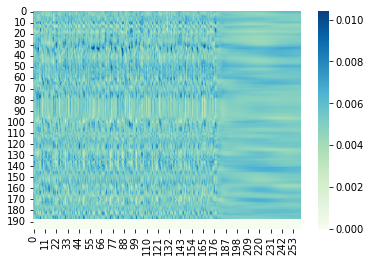

Val:   0%|          | 0/29 [00:00<?, ?it/s]

534.0040229885057

Epoch: 2/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

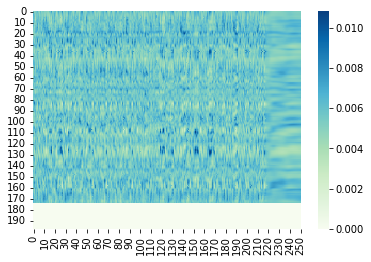

Val:   0%|          | 0/29 [00:00<?, ?it/s]

533.1614942528736

Epoch: 3/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

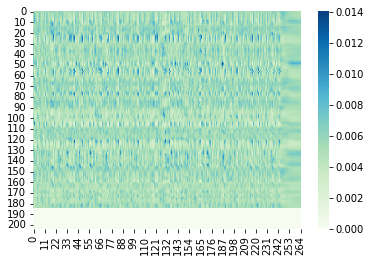

Val:   0%|          | 0/29 [00:00<?, ?it/s]

529.9096982758621

Epoch: 4/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

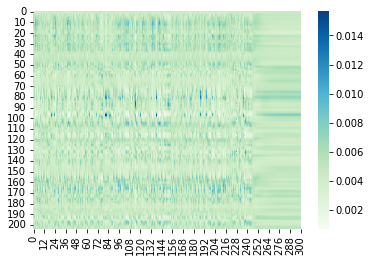

Val:   0%|          | 0/29 [00:00<?, ?it/s]

529.7456178160919

Epoch: 5/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

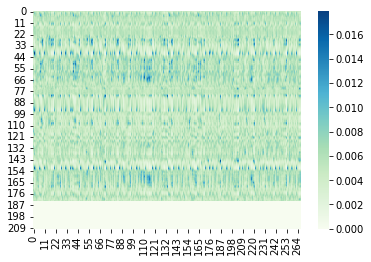

Val:   0%|          | 0/29 [00:00<?, ?it/s]

533.2190373563218

Epoch: 6/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

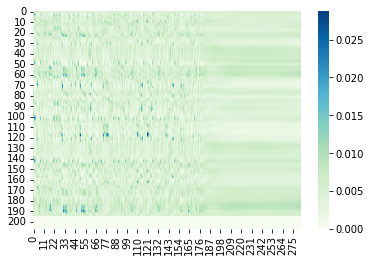

Val:   0%|          | 0/29 [00:00<?, ?it/s]

531.3372126436782

Epoch: 7/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

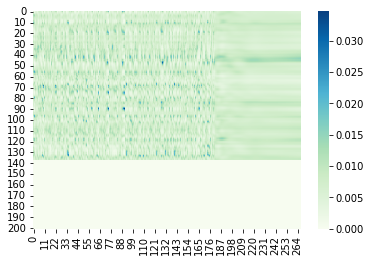

Val:   0%|          | 0/29 [00:00<?, ?it/s]

530.0694683908046

Epoch: 8/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

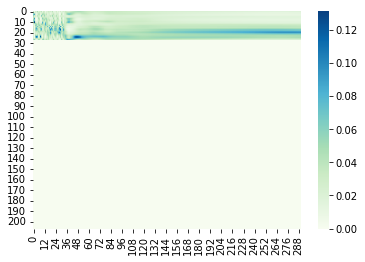

Val:   0%|          | 0/29 [00:00<?, ?it/s]

527.4342672413793

Epoch: 9/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

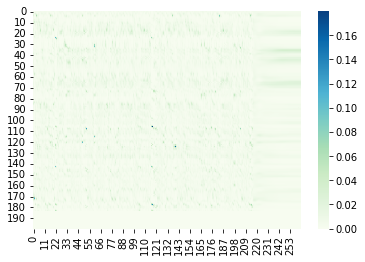

Val:   0%|          | 0/29 [00:00<?, ?it/s]

527.3122844827585

Epoch: 10/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

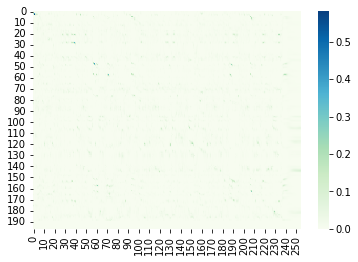

Val:   0%|          | 0/29 [00:00<?, ?it/s]

525.5879310344828

Epoch: 11/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

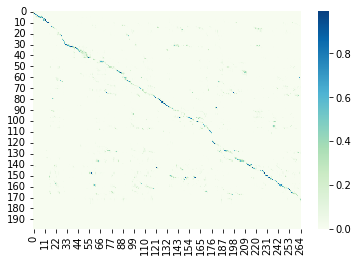

Val:   0%|          | 0/29 [00:00<?, ?it/s]

245.51975574712642

Epoch: 12/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

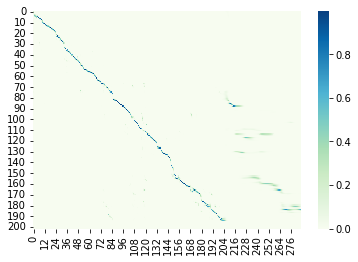

Val:   0%|          | 0/29 [00:00<?, ?it/s]

103.96293103448274

Epoch: 13/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

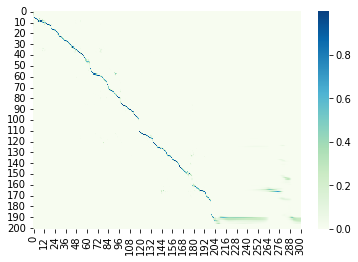

Val:   0%|          | 0/29 [00:00<?, ?it/s]

58.41127873563218

Epoch: 14/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

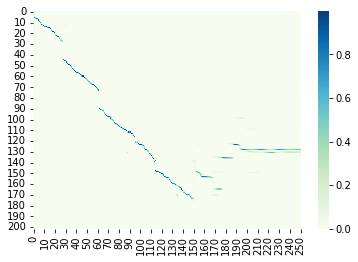

Val:   0%|          | 0/29 [00:00<?, ?it/s]

43.70962643678161

Epoch: 15/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

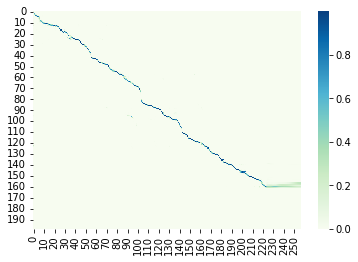

Val:   0%|          | 0/29 [00:00<?, ?it/s]

35.29281609195403

Epoch: 16/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

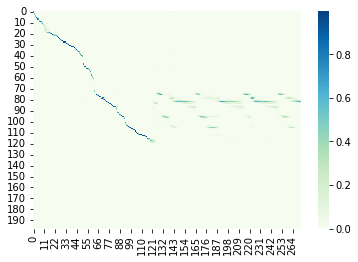

Val:   0%|          | 0/29 [00:00<?, ?it/s]

34.776149425287365

Epoch: 17/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

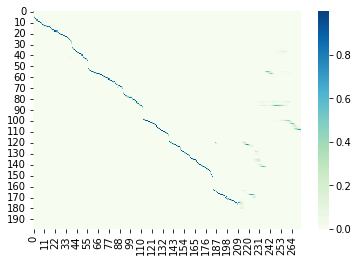

Val:   0%|          | 0/29 [00:00<?, ?it/s]

29.194324712643684

Epoch: 18/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

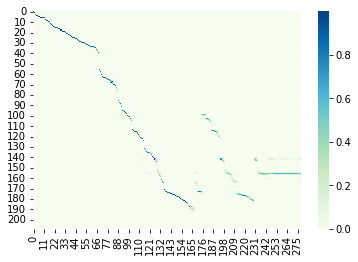

Val:   0%|          | 0/29 [00:00<?, ?it/s]

29.87061781609195

Epoch: 19/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

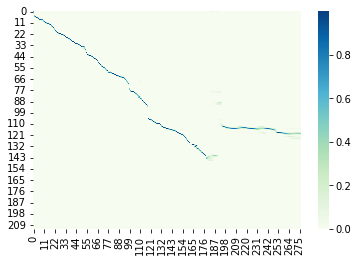

Val:   0%|          | 0/29 [00:00<?, ?it/s]

26.519396551724135

Epoch: 20/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

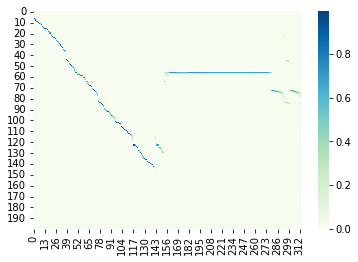

Val:   0%|          | 0/29 [00:00<?, ?it/s]

23.883333333333333

Epoch: 21/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

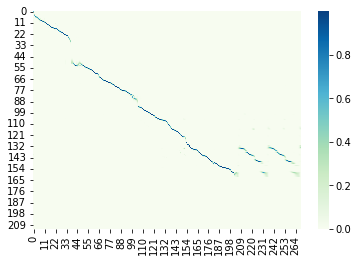

Val:   0%|          | 0/29 [00:00<?, ?it/s]

21.34238505747126

Epoch: 22/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

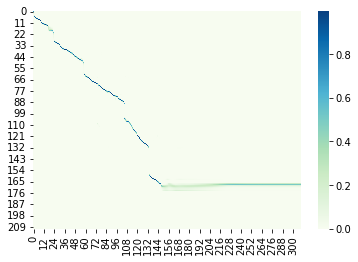

Val:   0%|          | 0/29 [00:00<?, ?it/s]

20.949066091954027

Epoch: 23/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

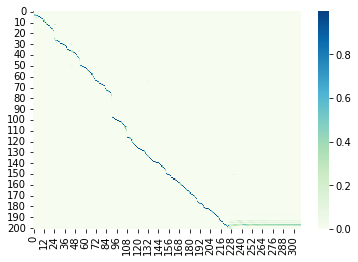

Val:   0%|          | 0/29 [00:00<?, ?it/s]

19.520977011494256

Epoch: 24/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

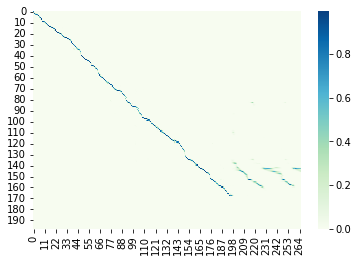

Val:   0%|          | 0/29 [00:00<?, ?it/s]

18.566379310344825

Epoch: 25/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

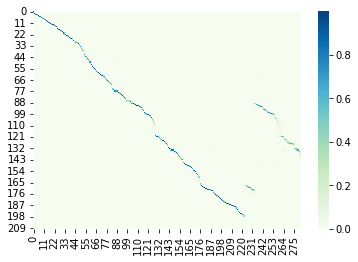

Val:   0%|          | 0/29 [00:00<?, ?it/s]

18.72198275862069

Epoch: 26/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

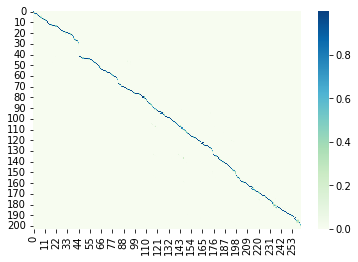

Val:   0%|          | 0/29 [00:00<?, ?it/s]

20.460632183908046

Epoch: 27/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

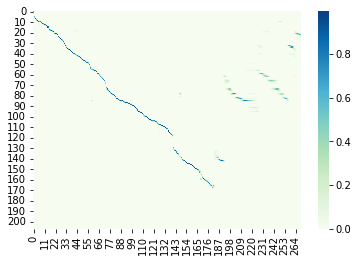

Val:   0%|          | 0/29 [00:00<?, ?it/s]

17.627083333333335

Epoch: 28/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

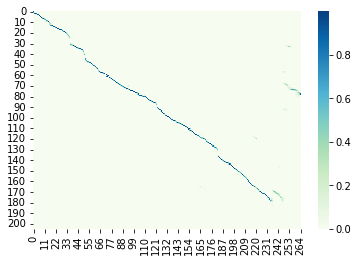

Val:   0%|          | 0/29 [00:00<?, ?it/s]

16.668318965517244

Epoch: 29/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

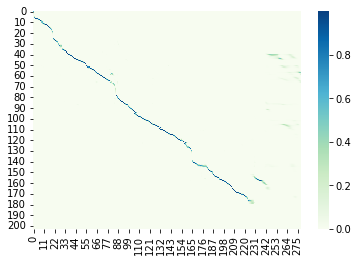

Val:   0%|          | 0/29 [00:00<?, ?it/s]

15.60229885057471

Epoch: 30/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

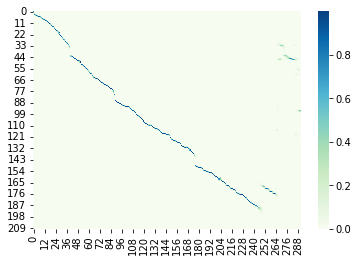

Val:   0%|          | 0/29 [00:00<?, ?it/s]

16.330675287356325

Epoch: 31/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

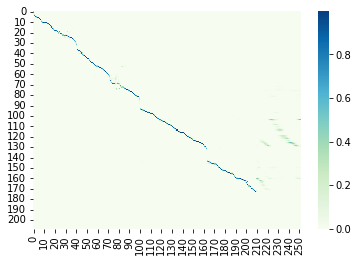

Val:   0%|          | 0/29 [00:00<?, ?it/s]

15.786566091954025

Epoch: 32/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

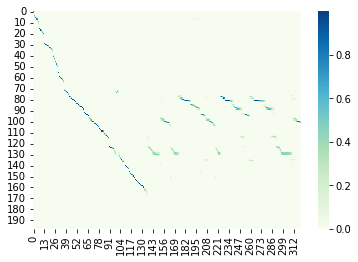

Val:   0%|          | 0/29 [00:00<?, ?it/s]

41.92327586206897

Epoch: 33/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

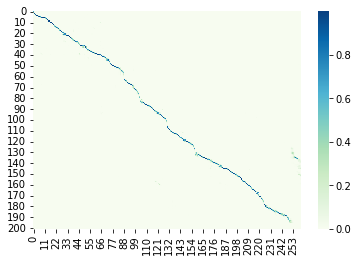

Val:   0%|          | 0/29 [00:00<?, ?it/s]

17.04906609195402

Epoch: 34/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

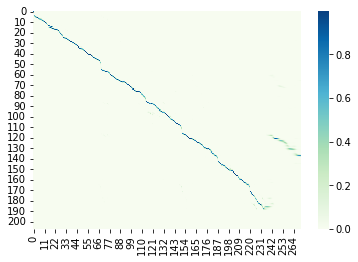

Val:   0%|          | 0/29 [00:00<?, ?it/s]

15.458261494252874

Epoch: 35/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

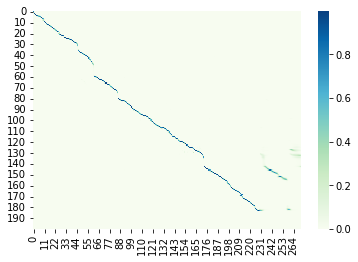

Val:   0%|          | 0/29 [00:00<?, ?it/s]

16.85919540229885

Epoch: 36/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

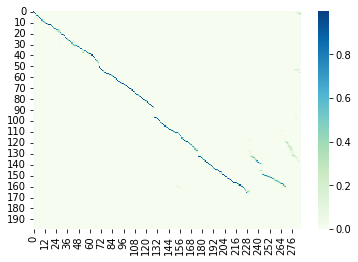

Val:   0%|          | 0/29 [00:00<?, ?it/s]

14.949353448275865

Epoch: 37/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

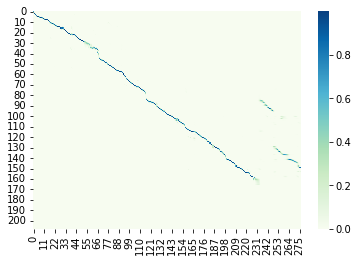

Val:   0%|          | 0/29 [00:00<?, ?it/s]

14.44877873563218

Epoch: 38/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

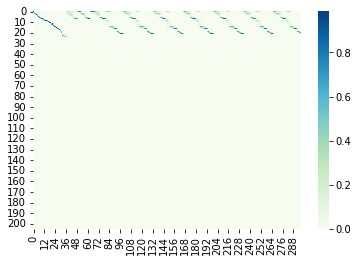

Val:   0%|          | 0/29 [00:00<?, ?it/s]

13.840589080459768

Epoch: 39/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

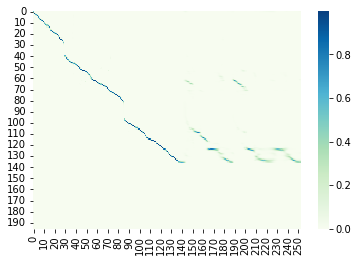

Val:   0%|          | 0/29 [00:00<?, ?it/s]

14.199784482758623

Epoch: 40/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

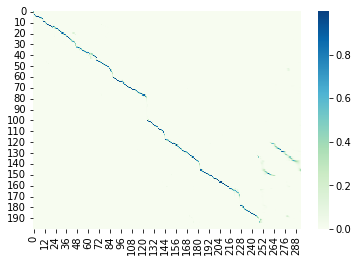

Val:   0%|          | 0/29 [00:00<?, ?it/s]

14.00977011494253

Epoch: 41/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

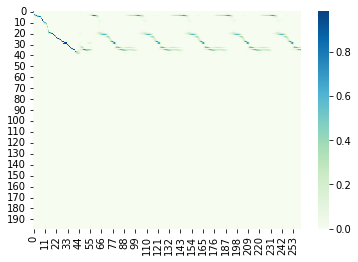

Val:   0%|          | 0/29 [00:00<?, ?it/s]

14.097701149425289

Epoch: 42/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

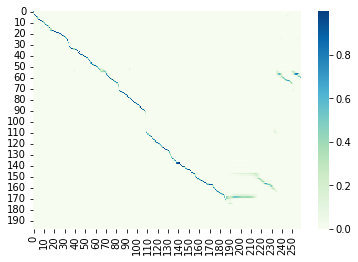

Val:   0%|          | 0/29 [00:00<?, ?it/s]

13.07104885057471

Epoch: 43/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

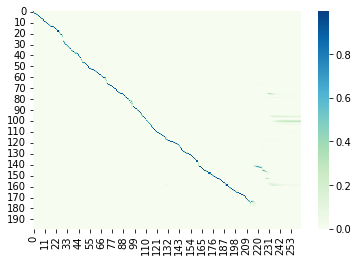

Val:   0%|          | 0/29 [00:00<?, ?it/s]

13.724281609195403

Epoch: 44/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

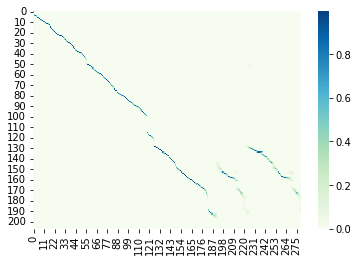

Val:   0%|          | 0/29 [00:00<?, ?it/s]

12.250000000000002

Epoch: 45/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

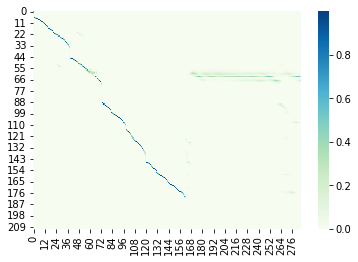

Val:   0%|          | 0/29 [00:00<?, ?it/s]

13.07385057471264

Epoch: 46/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

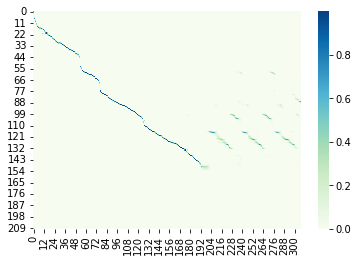

Val:   0%|          | 0/29 [00:00<?, ?it/s]

13.755603448275862

Epoch: 47/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

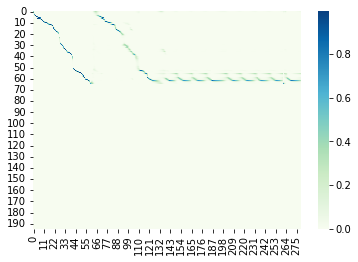

Val:   0%|          | 0/29 [00:00<?, ?it/s]

12.374281609195402

Epoch: 48/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

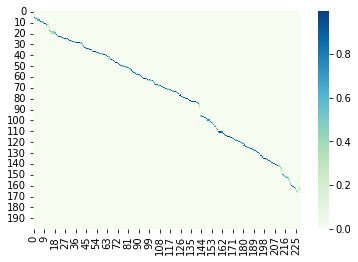

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 7.0000e-04.
12.82198275862069

Epoch: 49/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

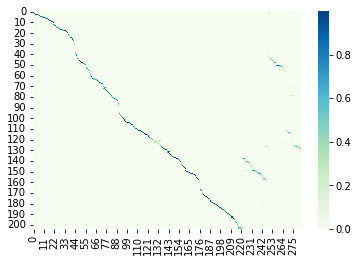

Val:   0%|          | 0/29 [00:00<?, ?it/s]

11.573850574712644

Epoch: 50/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

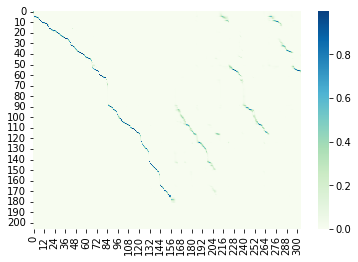

Val:   0%|          | 0/29 [00:00<?, ?it/s]

11.302945402298848

Epoch: 51/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

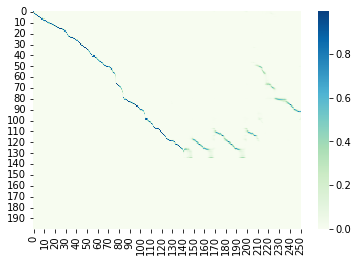

Val:   0%|          | 0/29 [00:00<?, ?it/s]

11.637715517241377

Epoch: 52/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

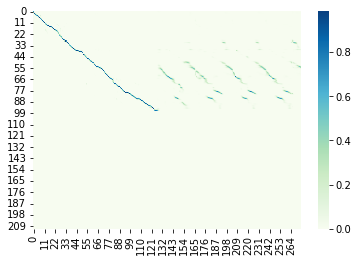

Val:   0%|          | 0/29 [00:00<?, ?it/s]

13.455100574712644

Epoch: 53/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

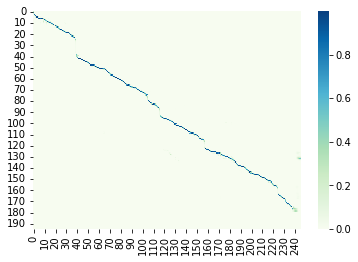

Val:   0%|          | 0/29 [00:00<?, ?it/s]

11.508261494252872

Epoch: 54/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

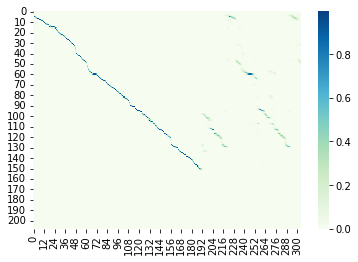

Val:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 4.9000e-04.
11.692313218390805

Epoch: 55/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

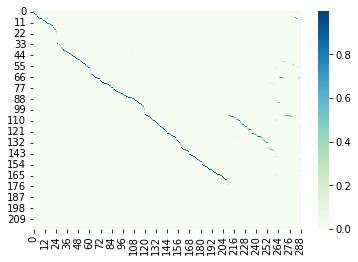

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.890876436781607

Epoch: 56/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

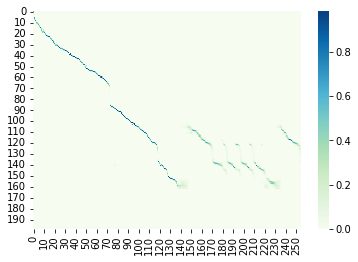

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.986494252873564

Epoch: 57/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

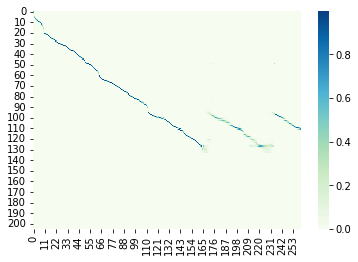

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.848563218390805

Epoch: 58/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

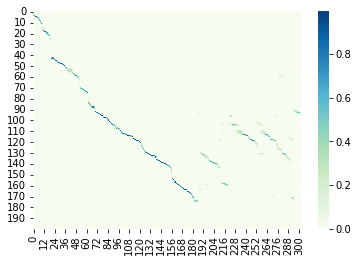

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.596982758620692

Epoch: 59/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

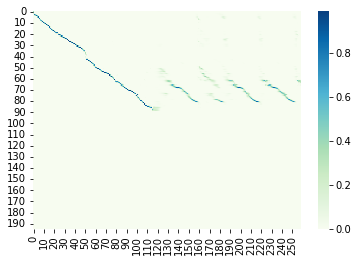

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.81508620689655

Epoch: 60/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

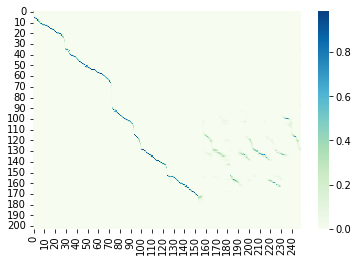

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.536637931034482

Epoch: 61/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

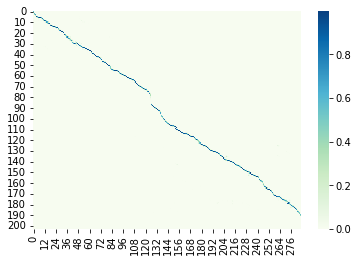

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.53383620689655

Epoch: 62/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

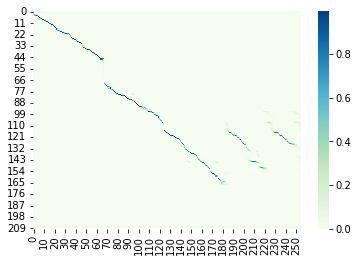

Val:   0%|          | 0/29 [00:00<?, ?it/s]

11.013002873563215

Epoch: 63/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

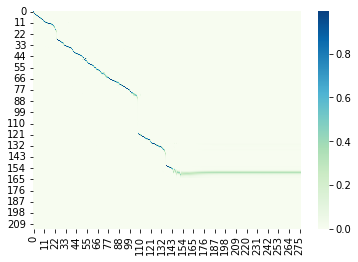

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.617385057471264

Epoch: 64/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

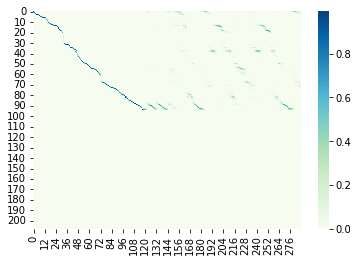

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.410991379310344

Epoch: 65/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

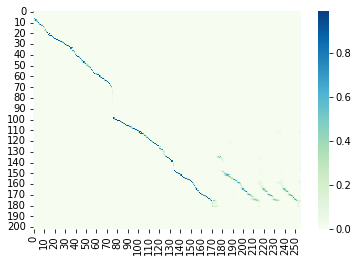

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.604454022988508

Epoch: 66/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

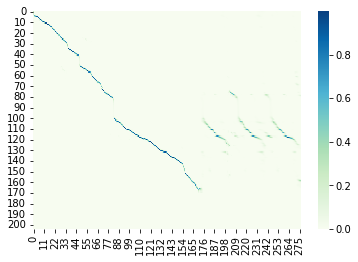

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.250646551724136

Epoch: 67/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

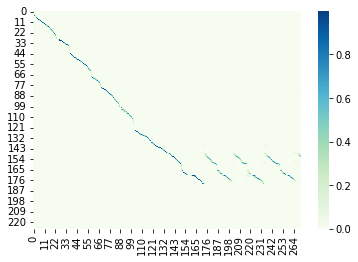

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.520474137931036

Epoch: 68/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

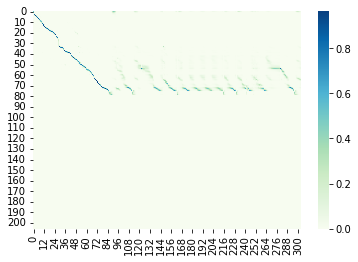

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.628663793103449

Epoch: 69/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

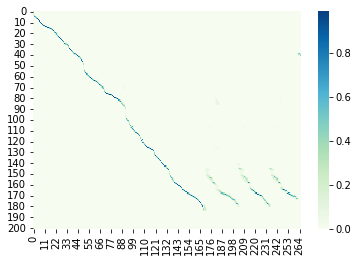

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.188146551724138

Epoch: 70/70


Train:   0%|          | 0/298 [00:00<?, ?it/s]

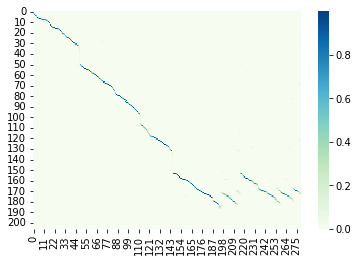

Val:   0%|          | 0/29 [00:00<?, ?it/s]

10.140660919540233


In [ ]:
best_lev_dist = 1e30
#checkpoint["val_dist"]
tf_rate = 1

for epoch in range(0, config['epochs']):
    
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    

    running_loss, running_perplexity, attention_plot=train(model, train_loader , criterion, optimizer, tf_rate)
   
    plot_attention(attention_plot)
    valid_dist=validate(model, val_loader)
    if epoch>35:
      lr_scheduler.step(valid_dist)
      if epoch%5==0:
        tf_rate-=0.015
      
    print(valid_dist)

  


    if valid_dist <= best_lev_dist:
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_dist': valid_dist, 
                  'epoch': epoch,
                  "scheduler":lr_scheduler.state_dict()}, '/content/drive/MyDrive/hw_4_3rdrun_7.pth')
      best_lev_dist = valid_dist
      # Save your model checkpoint here

43


In [ ]:
config

{'batch_size': 96, 'epochs': 30, 'lr': 0.001}

# Testing

In [ ]:
def predict(model,dataloader):
  model.eval()
  out=[]
  for i,data in enumerate(dataloader):
    x,lx=data
    x,lx=x.to(DEVICE),lx
    with torch.inference_mode():
      predictions, attentions = model(x, lx, y = None)
    predictions = model(x,lx)[0]
   
    greedy_predictions   =  predictions.argmax(-1).detach().cpu().numpy()

    for batch_idx in range(len(x)): 
      temp=greedy_predictions[batch_idx]
      cur=indices_to_chars(temp, VOCAB)
      cur="".join(cur)
      out.append(cur)
  return out

In [ ]:
predictions = predict( model,test_loader)

df = pd.read_csv('/content/data/hw4p2/test-clean/transcript/random_submission.csv')
df.label = predictions
df=df.rename(columns={"index": "id"})
df.to_csv('submission.csv', index = False)

In [ ]:
print(pd.read_csv('submission.csv'))

        id                                              label
0        0  HE BEGAN A CONFUSED COMPLAINT AGAINST THE WHIS...
1        1  KIHIM NOT SO EARNEST A MIND TO THESE MUMMERY H...
2        2                  A GOLDEN FORTUNE AND A HAPPY LIFE
3        3  HE WAS LIKE UNTO MY FATHER IN A WAY THEN YET W...
4        4  ALSO THERE WAS A STRIPLING PAGE WHO TURNED INT...
...    ...                                                ...
2615  2615                      HE HAD GOT INTO HER COURTYARD
2616  2616  THREE THE BLACK NIGHT RAIN HE SANG TO HER WIND...
2617  2617  THAT WAS BUT RUSTLING AS TRADING PLANTS IN THE...
2618  2618                           SHE WAS ALONE THAT NIGHT
2619  2619                HE HAD BROKEN INTO HER QUARRY ARMED

[2620 rows x 2 columns]


In [ ]:
!kaggle competitions submit -c 11-785-f22-hw4p2 -f submission.csv -m "Message"

100% 290k/290k [00:03<00:00, 97.2kB/s]
Successfully submitted to Attention-Based Speech Recognition